In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [46]:
import string
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM
from sklearn.metrics import accuracy_score

In [47]:
df1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

In [48]:
df1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [49]:
df2 = df1.drop(columns=['article_link'])

In [50]:
x_train, x_test, y_train, y_test = train_test_split(df2['headline'], df2['is_sarcastic'], test_size=0.2, stratify=df2['is_sarcastic'], random_state=1337)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train.head()

(21367,) (5342,) (21367,) (5342,)


8221     police fatally shoot black man in san diego su...
18232    ferguson protesters chain mall doors shut in s...
13826    ambitious social media startup has long-term 3...
21272    ice cube that man couldn't pry from tray lives...
3965     poll: ted cruz currently leads among voters di...
Name: headline, dtype: object

In [51]:
y_train.value_counts()

0    11988
1     9379
Name: is_sarcastic, dtype: int64

In [52]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<oov>")
tokenizer.fit_on_texts(x_train)

In [53]:
print(tokenizer.texts_to_sequences(["How are you doing maaan", "you doing how", "maaan are"]))

[[25, 31, 18, 386, 1], [18, 386, 25], [1, 31]]


In [54]:
x_train_enc = tokenizer.texts_to_sequences(x_train)
max_seq_length = max(len(x) for x in x_train_enc)
x_train_enc = np.array([np.pad(x, (0, max_seq_length - len(x))) for x in x_train_enc])

In [55]:
x_train_enc[:5]

array([[  112,  3973,  2237,    99,    14,     5,  1046,  4460, 13200,
         5083,  1239,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  905,   932,  2569,  1301,  3974,  1346,     5,  2376,   730,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 5084,   431,   240,  2570,    40,   235,  1541,   100,   432,
          193,     6,   329,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  675,  5923,    26,    14,  

In [56]:
vocab_size = len(tokenizer.word_index) + 1  # the +1 is for the 0
embed_size = 2

model = tf.keras.models.Sequential([
    Embedding(vocab_size, embed_size, input_shape=[None]),
    LSTM(embed_size, return_sequences=True),
    LSTM(embed_size),
    Dense(1, activation='sigmoid')
])
model.summary()
# Try diff activation functions

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           53120     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 2)           40        
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 53,203
Trainable params: 53,203
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_enc, y_train, epochs=5)

Epoch 1/5
668/668 [==============================] - 19s 25ms/step - loss: 0.6870 - accuracy: 0.5626
Epoch 2/5
668/668 [==============================] - 16s 24ms/step - loss: 0.6104 - accuracy: 0.6641
Epoch 3/5
668/668 [==============================] - 16s 24ms/step - loss: 0.3792 - accuracy: 0.8728
Epoch 4/5
668/668 [==============================] - 15s 23ms/step - loss: 0.2778 - accuracy: 0.9103
Epoch 5/5
668/668 [==============================] - 16s 23ms/step - loss: 0.1994 - accuracy: 0.9382


In [58]:
history = model.fit(x_train_enc, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
668/668 [==============================] - 16s 23ms/step - loss: 0.1466 - accuracy: 0.9572
Epoch 2/20
668/668 [==============================] - 16s 24ms/step - loss: 0.1080 - accuracy: 0.9715
Epoch 3/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0811 - accuracy: 0.9809
Epoch 4/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0639 - accuracy: 0.9868
Epoch 5/20
668/668 [==============================] - 16s 23ms/step - loss: 0.0528 - accuracy: 0.9897
Epoch 6/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0450 - accuracy: 0.9914
Epoch 7/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0409 - accuracy: 0.9927
Epoch 8/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0371 - accuracy: 0.9935
Epoch 9/20
668/668 [==============================] - 16s 23ms/step - loss: 0.0340 - accuracy: 0.9938
Epoch 10/20
668/668 [==============================] - 16s 24ms/step - loss: 0.031

In [59]:
x_test_enc = tokenizer.texts_to_sequences(x_test)
y_test = np.array(y_test)

n = 100
y_test_pred_n = []
for i in range(len(y_test[:n])):
    pred = model.predict(np.array([x_test_enc[i]]))
    y_test_pred_n.append(pred.ravel())

y_test_pred_n = np.array(y_test_pred)
y_test_pred_n = y_test_pred_n >= 0.5

print(accuracy_score(y_test[:n], y_test_pred_n))

0.76


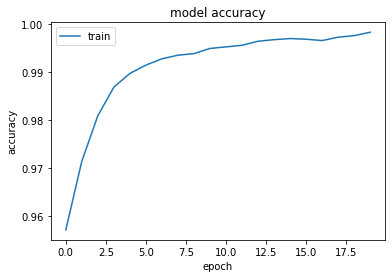

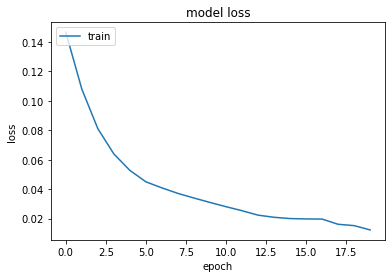

<Figure size 432x288 with 0 Axes>

In [60]:
# Summary
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [82]:
from keras.preprocessing.sequence import pad_sequences

headline = ['The stock market rose 10% this year']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=32,verbose = 1)
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcastic")

1/1 [==============================] - 0s 17ms/step
Non-sarcastic


In [78]:
df1['headline'].iloc[2:4]

2    mom starting to fear son's web series closest ...
3    boehner just wants wife to listen, not come up...
Name: headline, dtype: object